In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
!pip install --quiet shap
import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input


     |████████████████████████████████| 575 kB 7.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Alzheimer disease Classification')

In [ ]:
# %%capture
# !unzip /content/drive/MyDrive/ADNI/ADNI1_Complete.zip -d /content

In [ ]:
W = 128 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 128 # The default size for ResNet is 224 but resize to .5 to save memory size

label_to_class = {
    'Mild_Demented': 0,
    'Very_Mild_Demented': 1,
    'Non_Demented': 2,
    'Moderate_Demented':3,   
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='dataset', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for j in ['/Dataset']:
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                img = img_to_array(img)

                Images.append(img)
                Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [ ]:
## get images / labels
# get_images()
Images, Classes = get_images()

Images.shape, Classes.shape

((6400, 128, 128, 3), (6400,))

In [ ]:
Classes

array([2., 0., 2., ..., 1., 0., 0.], dtype=float32)

In [ ]:
## split train / test

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=True)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 128, 128, 3), (5120,), (1280, 128, 128, 3), (1280,))

In [ ]:
y_test

array([0., 0., 1., ..., 2., 2., 2.], dtype=float32)

In [ ]:
from keras.utils import np_utils

In [ ]:
y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((5120, 4), (1280, 4))

In [ ]:
y_train

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [ ]:
y_test

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 128, 128, 3), (5120, 4), (1280, 128, 128, 3), (1280, 4))

In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 36.6 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
num_classes = 4
input_shape = (128,128, 3)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 128, 128, 3), (5120, 4), (1280, 128, 128, 3), (1280, 4))

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 128  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x) # GELU activation function
        x = layers.Dropout(dropout_rate)(x) # Dropout layer
    return x


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 6 X 6
Patches per image: 441
Elements per patch: 108


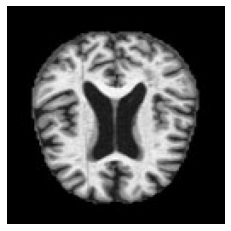

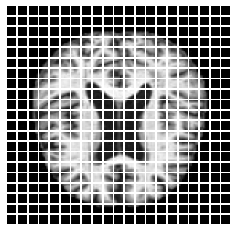

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation="sigmoid")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
from matplotlib import pyplot
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,cohen_kappa_score,roc_auc_score,plot_confusion_matrix,classification_report

In [ ]:
# compile the model
model = create_vit_classifier()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
)
model.summary()
# train the model
history = model.fit(
    x_train, y_train, batch_size=16, epochs=200, validation_split=0.25
)

# evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)} %")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 128, 128, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 441, 64)      35200       ['patches_1[0][0]']          

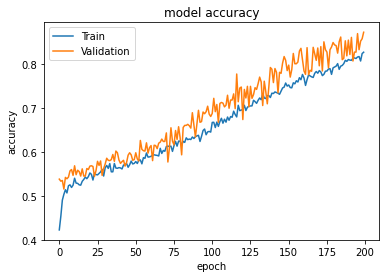

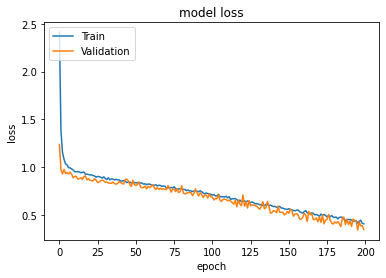

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'],label="train_acc")
plt.plot(history.history['val_accuracy'],label="val_acc")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("/content/drive/MyDrive/Alzheimer disease Classification/accuracyplot.png")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],label="train_loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("/content/drive/MyDrive/Alzheimer disease Classification/lossplot.png")
plt.show()

In [ ]:
y_pred=model.predict(x_test)

40/40 [==============================] - 4s 72ms/step


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
y_pred

array([0, 0, 1, ..., 1, 1, 2])

In [ ]:
len(y_test),len(y_pred)

(1280, 1280)

In [ ]:
y_test=np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[151,  26,   8,   1],
       [ 15, 414,  47,   0],
       [ 10,  87, 509,   0],
       [  1,   2,   0,   9]])

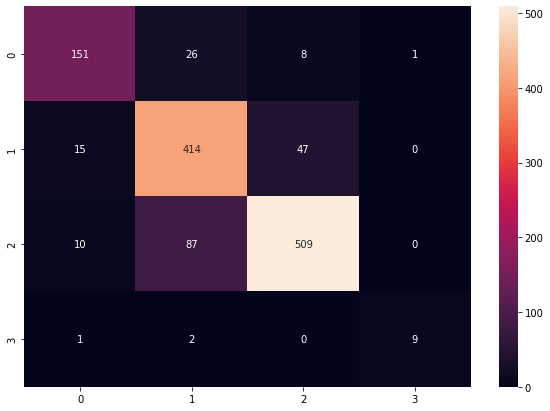

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='g')
plt.savefig("/content/drive/MyDrive/Alzheimer disease Classification/CM.png")

In [ ]:
classes = ['Mild_Demented','Very_Mild_Demented','Non_Demented','Moderate_Demented']  
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=classes))


                    precision    recall  f1-score   support

     Mild_Demented       0.85      0.81      0.83       186
Very_Mild_Demented       0.78      0.87      0.82       476
      Non_Demented       0.90      0.84      0.87       606
 Moderate_Demented       0.90      0.75      0.82        12

          accuracy                           0.85      1280
         macro avg       0.86      0.82      0.84      1280
      weighted avg       0.85      0.85      0.85      1280



In [ ]:
# # plot the training loss and accuracy
# N = 150
# plt.style.use("ggplot")
# # make plot bigger
# plt.rcParams["figure.figsize"] = (12, 8)
# plt.figure()
# plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig("lossplot.png")


In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)} %")

ValueError: ignored

In [ ]:
#y_train classes
y_train_classes = np.argmax(y_train, axis=1)
print(y_train_classes)

In [ ]:
plt.figure(figsize=(15, 15))
# plot loss during training
pyplot.subplot(221)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(222)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# history
print(f'The model has a best accuracy of {round(max(history.history["accuracy"])*100,2)}% and a best loss of {round(min(history.history["loss"]),2)}')
 
